# Problem set 2

## Team
Please write here your names and team number.

* Team name: A
* Team members: Giorgio Coppola, Luis Windpassinger, Laia Domenech Burin, Leticia Figueiredo Collado

## Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

## Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Make sure that all your work has been pushed to GitHub before the deadline.


Check that the GPU  enabled in your colab notebook by running the cell below.

In [12]:
import torch
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


In [ ]:
# Mac specific check

# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# test_x = torch.randn(3, 3, device=device)
# print(test_x)

tensor([[ 0.1480,  0.7735, -0.3143],
        [-0.4900,  1.2051,  1.2110],
        [ 0.1373, -0.2660,  0.3825]], device='mps:0')


You will be working with the EuroSAT dataset. The dataset contains 8489 pictures of 3 different land coverage types (crop, herbaceous vegetation and river). Running the lines below will download the data and return a random picture from the dataset.

The dataset has 27000 images
Picture number 23654 with label: 8


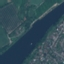

In [14]:
from torchvision.datasets import EuroSAT
import os
import numpy as np

data = EuroSAT(root=os.getcwd(), download=True) #downloads the dataset to your current directory
print(f"The dataset has {len(data)} images")
randint = np.random.randint(len(data))

pic, tar = data[randint]
print(f"Picture number {randint} with label: {tar}")
pic

# Task 1: Transform the data (10 pt)

 Your task is to train a classifier to classify the different land usage types in the dataset. We want to select only the 50 most frequent people in the dataset, all the other people should be mapped to a common class.
- Implement the class `rotate` that maps pictures to flipped pictures by 90, 180, 270 or 360°. The class should return an error if you try to rotate the picture by other degrees.
- Plot a histogram with the frequencies of each class. Make sure to insert both name and label in the histogram (e.g. `AnnualCrop:0`).
- We create a class `RotateEuroSAT` that takes as input the original dataset and returns a new dataset which contains randomly rotated pictures and whose label proportion can be customized.
Implement the class method `_create_rotated_dataset` that returns this pictures using the previously implemented `rotate`.
- `RotateEuroSAT` should also take care of transforming the pictures to tensors and optionally move the tensor to a GPU device.

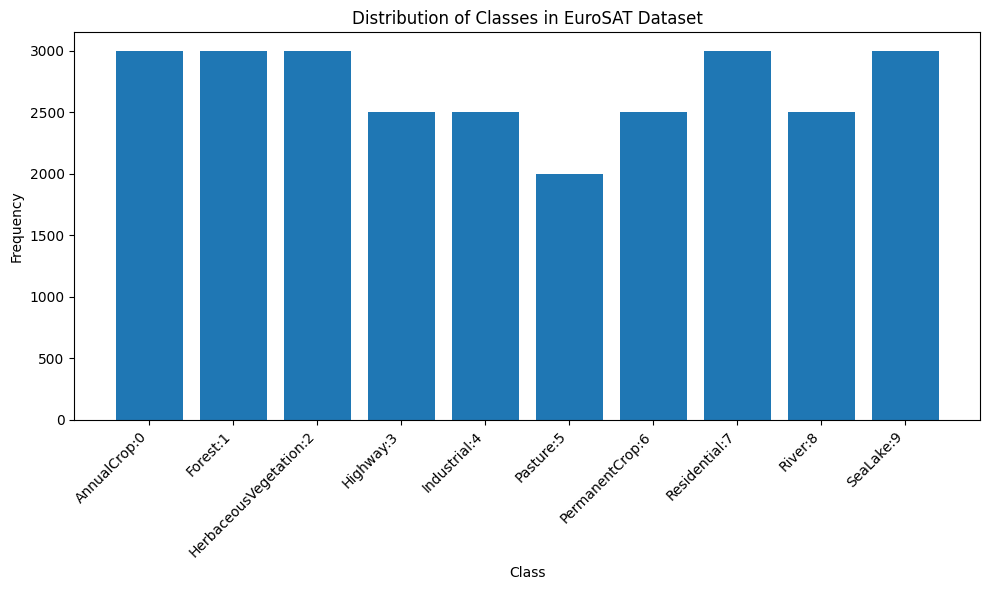

In [15]:
from torch.utils.data import Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
from torchvision.transforms import transforms
from collections import Counter

def rotate_picture(picture, rotation: int):

  acceptable = [90, 180, 270, 360]

  if rotation not in acceptable:
    raise ValueError(f"Must be one of {acceptable}")
  
  if rotation == 360:
    return picture

  else:
    picture = F.rotate(picture, rotation)

  return picture


def plot_histogram(data):

  labels = [tar for pic, tar in data]
  label_counts = Counter(labels)
  class_names = data.classes
  histogram_labels = [f"{class_names[label]}:{label}" for label in label_counts.keys()]
  counts = np.bincount(labels)

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.bar(histogram_labels, counts)
  ax.set_xlabel("Class")
  ax.set_ylabel("Frequency")
  ax.set_title("Distribution of Classes in EuroSAT Dataset")
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()

  return plt, ax


new_pic = rotate_picture(pic, 90) # Example of rotating a picture by 90 degrees
same_pic = rotate_picture(pic, 360) # Example of rotating a picture by 360 degrees (should return the same picture)
plt, ax = plot_histogram(data)
plt.show()

In [16]:
import random

class RotateEuroSAT(Dataset):
    def __init__(self,
                 original_data:Dataset,
                 length:int,
                 shares:list,
                 device=None,
                 seed=42):

        self.original_data = original_data
        self.length = length
        assert sum(shares)  == 1, "Shares must sum to 1"
        assert len(shares) == len(original_data.classes), "Shares must match number of classes"
        self.shares = shares
        self.seed = seed
        self.device = device
        self.dataset = self._create_rotated_dataset()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        picture, label = self.dataset[idx]
        if self.device:
            picture = picture.to(self.device)
        return picture, label

    def _create_rotated_dataset(self):
        """#TODO: implement solution"""

        random.seed(self.seed)
        np.random.seed(self.seed)

        # This first part is to calculate the shares in the new dataset,
        # depending on the sample size of the total dataset, and on the share size
        # (both are parameters we can decide):

        # Calculate the number of samples for each class based on shares and total length
        samples_per_class = [int(self.shares[i] * self.length) for i in range(len(self.shares))]
        # Adjust for potential rounding errors
        total_samples = sum(samples_per_class)
        if total_samples != self.length:
            diff = self.length - total_samples
            for i in range(abs(diff)):
                samples_per_class[i % len(self.shares)] += np.sign(diff)

        # Here is where the actual creation of the new dataset happens:

        rotated_data = []
        for class_idx, num_samples in enumerate(samples_per_class): # Iterating through classes
            # Find samples for the current class
            class_indices = [i for i, (_, label) in enumerate(self.original_data) if label == class_idx]
            # Randomly sample indices to meet the required number of samples for this class
            sampled_indices = random.choices(class_indices, k=num_samples)

            for idx in sampled_indices: # For each sample index
                picture, label = self.original_data[idx]
                # Apply random rotation
                rotation_angle = random.choice([90, 180, 270, 360])
                rotated_picture = rotate_picture(picture, rotation_angle)
                # Convert PIL image to tensor and normalize
                rotated_picture = F.to_tensor(rotated_picture)
                # Move to device if specified
                if self.device:
                  rotated_picture = rotated_picture.to(self.device)

                rotated_data.append((rotated_picture, label))

        # Shuffle the final dataset
        np.random.shuffle(rotated_data)

        return rotated_data

Text(0.5, 1.0, 'Rotated by 360°')

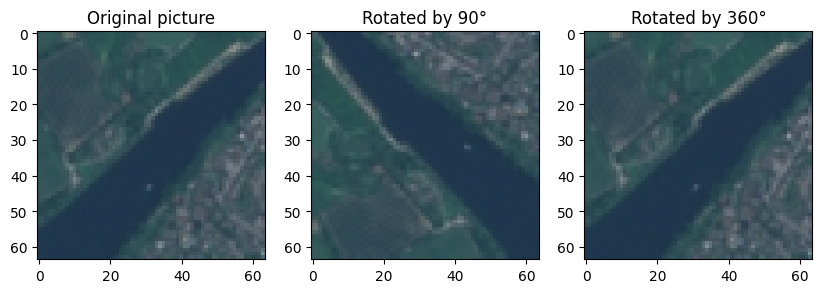

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pic)
axes[0].set_title("Original picture")
axes[1].imshow(new_pic)
axes[1].set_title("Rotated by 90°")
axes[2].imshow(same_pic)
axes[2].set_title("Rotated by 360°")

In [18]:
rotated_data = RotateEuroSAT(data,
                             length=10**4,
                             shares=[1 / len(data.classes) for _ in data.classes],
                             seed=42)

train_data, test_data = random_split(rotated_data, [0.8, 0.2])

## Task 2: Implement a max pooling class and a CNN model(15 pt)
Implement a classification model to predict the label of the faces in the dataset. You are free to experiment with the network architecture. However your model **must** contain:
- At least one max pooling layer, implemented with `MyMaxPool`,
- Convolutional, linear, and pooling layers only,
- At least 3 convolutional layers, with at least two different kernel sizes,
- A final output layer that is customizable to the number of classes that we want to predict.

#### Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences).


In [19]:
import torch
import torch.nn as nn

class MyMaxPool(nn.Module):
    def __init__(self,
                 kernel_size,
                 stride=None,
                 padding=0):
      
        super().__init__()
        # if stride is not provided, use kernel_size (for non-overlapping pooling)
        actual_stride = kernel_size if stride is None else stride
        self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=actual_stride, padding=padding)

    def forward(self, x):
        return self.pool(x)

class MyCNNModel(nn.Sequential):

  def __init__(self,
               n_classes,
               in_channels=3):

    super().__init__()
    
    self.convolutions = nn.Sequential(
      nn.Conv2d(in_channels, 32, kernel_size=3, padding=1), # kernel size 3
      nn.ReLU(inplace=True),
      MyMaxPool(kernel_size=2),

      nn.Conv2d(32, 64, kernel_size=3, padding=1), # kernel size 3
      nn.ReLU(inplace=True),
      MyMaxPool(kernel_size=2),

      nn.Conv2d(64, 128, kernel_size=5, padding=2), # kernel size 5
      nn.ReLU(inplace=True),
      MyMaxPool(kernel_size=2),
    )
    
    self.classifier = nn.Sequential(
      nn.AdaptiveAvgPool2d((1,1)),
      nn.Flatten(),
      nn.Dropout(0.5), # dropout for regularization as explained below
      nn.Linear(128, n_classes)
    )

  def forward(self, x):
    x = self.convolutions(x)
    x = self.classifier(x)
    return x



In [20]:
'''#TODO: print one iteration of your model to test its correctness'''

my_model = MyCNNModel(n_classes=10, in_channels=3)
X, y = train_data[0]
my_model(X[None, :])

tensor([[-0.1223,  0.0027,  0.0892,  0.0235, -0.0576, -0.0022, -0.1364,  0.0151,
         -0.0813, -0.0227]], grad_fn=<AddmmBackward0>)

**Reasoning for model architecture:**

This VGG-style architecture uses a hierarchical design with stacks of small 3×3 convolutional filters followed by a larger 5×5 filter to capture both fine local details and broader spatial structures in the 64×64 input images, while keeping the parameter count manageable.

Max-pooling layers interleaved after each convolutional block serve multiple purposes: they downsample feature maps (halving spatial dimensions), increase the receptive field to capture larger-scale patterns, improve computational efficiency, and add translation invariance, particularly valuable for land-cover classification where textures and objects may appear at varying positions within images.

The adaptive average pooling layer produces a fixed-size embedding regardless of input dimensions, enabling the architecture to handle variable input sizes while further regularizing against overfitting. This feeds into a fully-connected classification layer with dropout that provides sufficient capacity to separate the classes while preventing overfitting[^1] on the relatively small dataset.

The architectural choices follow PyTorch best practices but could be further tuned: the progression from small to larger kernels captures multi-scale features, the pooling strategy balances spatial invariance with information retention, and the regularization techniques (dropout and average pooling) work together to maintain generalization performance.

[^1]: Hinton et al. (2012) https://arxiv.org/abs/1207.0580

## Training

We define a `Trainer` function to train our model that returns avg loss and avg accuracy per epoch. We set the configuration of the trainer is set in the `cfg` dictionary. Use the trainer to train your model and make sure to print and plot avg loss and accuracy using the in-built commands.

In [21]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

cfg = {
    'batch_size': 64,
    'criterion': 'CrossEntropyLoss', #change to 'nn.NLLLoss' if you are applying a softmax in the last layer of your model
    'epochs': 3,
    'learning_rate': 0.001,
    'optimizer':'Adam',
    'seed':42,

}

class Trainer:

    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg

        for key, val in cfg.items():
            setattr(self, key, val)

        self.optimizer = getattr(optim, self.optimizer)(self.model.parameters(), lr=self.learning_rate)
        self.criterion = getattr(nn, self.criterion)()


    def iter_step(self, X, Y):
        Y_pred = self.model(X)
        loss = self.criterion(Y_pred, Y)
        acc = (Y_pred.argmax(dim=-1) == Y).to(torch.float).mean()
        return loss, acc

    def train(self, dataset):
        train_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))
        avg_loss, avg_acc = [], []
        tot_loss, tot_acc = 0, 0
        for epoch in range(self.epochs):
            iterdata = iter(train_dataloader)
            train_size = len(iterdata)
            pbar = tqdm(iterable=range(train_size))

            for i in pbar:
                batch = next(iterdata)
                X_batch, Y_batch = batch #this is needed for compatibility with pbar
                self.model.train()
                self.optimizer.zero_grad()
                loss, acc = self.iter_step(X_batch, Y_batch)
                loss.backward()
                self.optimizer.step()
                tot_loss += loss.item()
                tot_acc += acc.item()
                avg_loss.append(tot_loss / max(1, len(avg_loss)))
                avg_acc.append(tot_acc / max(1, len(avg_acc)))
                desc = f'Epoch:{epoch} - Avg loss:{avg_loss[-1]:.5f} - Avg acc:{avg_acc[-1]:.5f}'
                pbar.set_description(desc)

        return avg_loss, avg_acc

    def test(self, dataset):
        avg_test_loss, avg_test_acc = [], []
        test_loss, test_acc = 0, 0
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))

        for X_batch, Y_batch in iter(test_dataloader):
            loss, acc = self.iter_step(X_batch, Y_batch)
            test_loss += loss.item()
            test_acc += acc
            avg_test_loss.append(test_loss / max(1, len(avg_test_loss)))
            avg_test_acc.append(test_acc / max(1, len(avg_test_acc)))

        return avg_test_loss, avg_test_acc



Epoch:2 - Avg loss:1.57060 - Avg acc:0.40817: 100%|██████████| 125/125 [00:14<00:00,  8.50it/s]


Text(0.5, 1.0, 'Training accuracy')

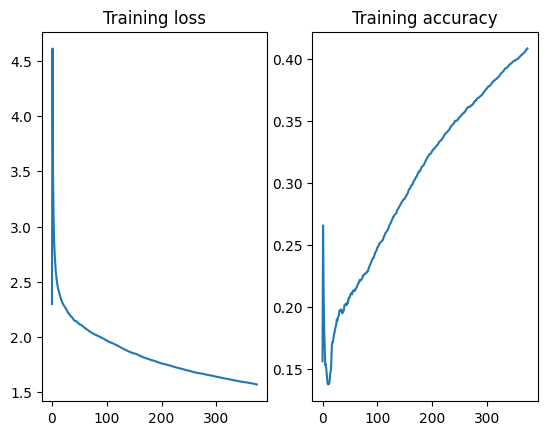

In [22]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
my_trainer = Trainer(my_model, cfg)
train_loss_vanilla, train_acc_vanilla = my_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss_vanilla)), train_loss_vanilla)
ax1.plot(range(len(train_acc_vanilla)), train_acc_vanilla)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

Text(0.5, 1.0, 'Test accuracy')

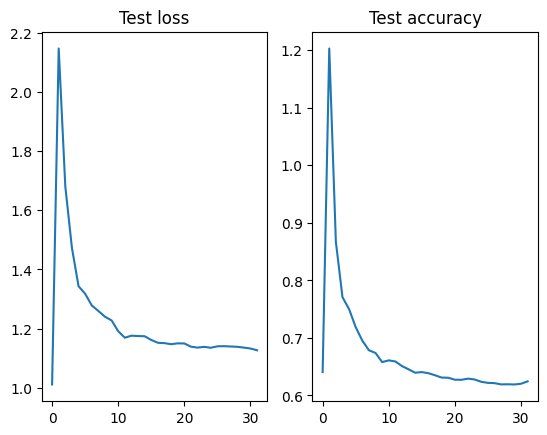

In [23]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss_vanilla, test_acc_vanilla = my_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss_vanilla)), test_loss_vanilla)
ax1.plot(range(len(test_acc_vanilla)), test_acc_vanilla)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

**Comment**

After looking at this plot we realized two things:

- The accuracy on the test per batch exceeds 1, which is illogical considering an accuracy range of [0,1]. This suggests a bug in the code.
- The plot shows accuracy per minibatch, instead of plotting by epoch. In the context of training this plotting approach makes sense, however, in the test case it does not provide a comprehensive performance measure and is not interpretable. Therefore, we would suggest plotting the avg accuracy per epoch, instead of per minibatch, or generally evaluate accuracy per label.
  
Since this code was given, we refrained from changing it.

## Task 3: Tune your training hyperparameters (optional, 10 pt)

Implement a method <code>grid_search</code>, which looks for the best possible learning rates and training batch sizes for your model <code>MyCNNModel</code> and returns the best possible model, the corresponding training configuration, and the final training avg losses and accuracies (as numbers).

In [24]:
def grid_search(train_dataset, test_dataset, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7]):
    best_loss = float('inf')
    best_acc = 0
    best_model = None
    best_cfg = None

    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"Training with learning rate: {lr}, batch size: {bs}")
            current_cfg = cfg.copy()
            current_cfg['learning_rate'] = lr
            current_cfg['batch_size'] = bs

            model = MyCNNModel(n_classes=10,
                               in_channels=3)
            trainer = Trainer(model, current_cfg)

            # Train the model (we'll select using TRAINING averages)
            train_loss, train_acc = trainer.train(train_dataset)
            avg_train_loss = train_loss[-1] if train_loss else float('inf')
            avg_train_acc  = train_acc[-1]  if train_acc  else 0.0

            # Report test metrics
            test_loss, test_acc = trainer.test(test_dataset)
            avg_test_loss = test_loss[-1] if test_loss else float('inf')
            avg_test_acc  = test_acc[-1]  if test_acc  else 0.0
            print(f"Finished training with learning rate: {lr}, batch size: {bs} - Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}")

            # Select best by TRAIN accuracy; tie-break by TRAIN loss
            if (avg_train_acc > best_acc) or (avg_train_acc == best_acc and avg_train_loss < best_loss):
                best_acc = avg_train_acc
                best_loss = avg_train_loss
                best_model = model
                best_cfg = current_cfg.copy()

    return best_model, best_cfg, best_loss, best_acc

# Try:
best_model, best_cfg, train_loss_tuned, train_acc_tuned = grid_search(train_data, test_data, cfg,
                                                                learning_rates=[10**-1, 10**-2, 10**-3],
                                                                batch_sizes=[2**5, 2**6, 2**7])
print(f"Best model achieves {train_loss_tuned:.2f} training loss and {train_acc_tuned:.1%} training accuracy")


Training with learning rate: 0.1, batch size: 32


Epoch:2 - Avg loss:7.10883 - Avg acc:0.09972: 100%|██████████| 250/250 [00:15<00:00, 15.97it/s]


Finished training with learning rate: 0.1, batch size: 32 - Test Loss: 2.3609, Test Acc: 0.0973
Training with learning rate: 0.1, batch size: 64


Epoch:2 - Avg loss:9.65889 - Avg acc:0.09947: 100%|██████████| 125/125 [00:15<00:00,  8.26it/s] 


Finished training with learning rate: 0.1, batch size: 64 - Test Loss: 2.3917, Test Acc: 0.0973
Training with learning rate: 0.1, batch size: 128


Epoch:2 - Avg loss:11.38220 - Avg acc:0.09649: 100%|██████████| 63/63 [00:14<00:00,  4.38it/s]


Finished training with learning rate: 0.1, batch size: 128 - Test Loss: 2.4609, Test Acc: 0.1057
Training with learning rate: 0.01, batch size: 32


Epoch:2 - Avg loss:1.73752 - Avg acc:0.31963: 100%|██████████| 250/250 [00:15<00:00, 15.67it/s]


Finished training with learning rate: 0.01, batch size: 32 - Test Loss: 1.3030, Test Acc: 0.5721
Training with learning rate: 0.01, batch size: 64


Epoch:2 - Avg loss:1.70454 - Avg acc:0.33824: 100%|██████████| 125/125 [00:15<00:00,  8.19it/s]


Finished training with learning rate: 0.01, batch size: 64 - Test Loss: 1.3254, Test Acc: 0.5585
Training with learning rate: 0.01, batch size: 128


Epoch:2 - Avg loss:1.71968 - Avg acc:0.33598: 100%|██████████| 63/63 [00:15<00:00,  4.19it/s]


Finished training with learning rate: 0.01, batch size: 128 - Test Loss: 1.3023, Test Acc: 0.5847
Training with learning rate: 0.001, batch size: 32


Epoch:2 - Avg loss:1.51112 - Avg acc:0.43062: 100%|██████████| 250/250 [00:17<00:00, 14.35it/s]


Finished training with learning rate: 0.001, batch size: 32 - Test Loss: 1.2038, Test Acc: 0.5504
Training with learning rate: 0.001, batch size: 64


Epoch:2 - Avg loss:1.60457 - Avg acc:0.38987: 100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


Finished training with learning rate: 0.001, batch size: 64 - Test Loss: 1.2680, Test Acc: 0.5620
Training with learning rate: 0.001, batch size: 128


Epoch:2 - Avg loss:1.66848 - Avg acc:0.37047: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]


Finished training with learning rate: 0.001, batch size: 128 - Test Loss: 1.3722, Test Acc: 0.5585
Best model achieves 1.51 training loss and 43.1% training accuracy


## Task 3: Load and fine-tune a pre-trained model (10 pt)

<ul>
  <li>Load and train a pre-trained model for classification problems, such as those made available in <a href="https://huggingface.co/docs/timm">Hugging Face's timm library</a>. </li>
  <li> Make sure to modify the output layer to be compatible with the number of classes. </li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>
  
<b>Note</b>: in case you run into computing-related (e.g. memory) issues, consider choosing another model.

In [25]:
import timm

timm.list_models(pretrained=True, filter="*resnet18*")

/Users/luis/Library/CloudStorage/OneDrive-HertieSchool/year-2/semester-3/deepl/assignments/ps2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['legacy_seresnet18.in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet18d.ra4_e3600_r224_in1k',
 'skresnet18.ra_in1k']

In [26]:
'''#TODO: import and fine-tune a pretrained model'''
loaded_model = timm.create_model('resnet18.a2_in1k', pretrained=True, num_classes=10)
loaded_trainer = Trainer(loaded_model, cfg)

print(loaded_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

Epoch:2 - Avg loss:0.33346 - Avg acc:0.89555: 100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


Text(0.5, 1.0, 'Training accuracy')

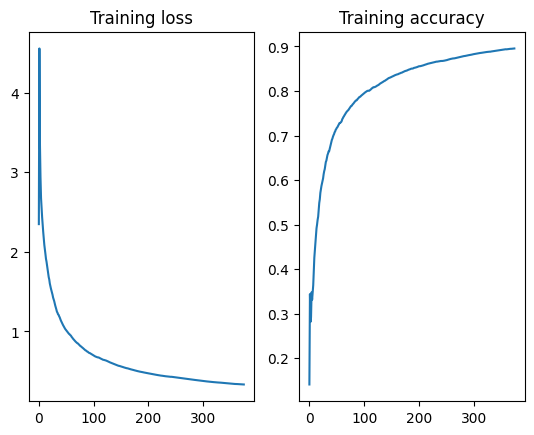

In [27]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
train_loss_pre, train_acc_pre = loaded_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss_pre)), train_loss_pre)
ax1.plot(range(len(train_acc_pre)), train_acc_pre)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

Text(0.5, 1.0, 'Test accuracy')

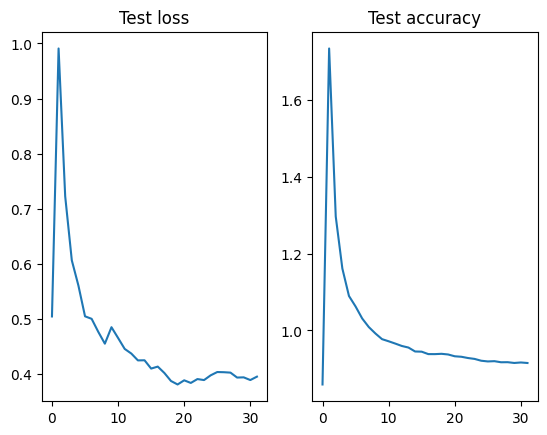

In [28]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss_pre, test_acc_pre = loaded_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss_pre)), test_loss_pre)
ax1.plot(range(len(test_acc_pre)), test_acc_pre)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

**Architecture**

We chose a ResNet-type model this family of model is very popular and widely used for image classification. Residual connections make optimization stable when unfreezing the backbone, and replacing only the final classifier adapts the model to our class count with modest memory/compute.

As Mittal et al. (2025)[^1] argue, "ResNet50" performs particularly well in satellite-image-based remote sensing tasks. In the light of resource constraints, we opted for a smaller version called "ResNet18". The model is, however, sufficient to prove its suitability, despite a smaller scope compared to "ResNet50".

[^1]: https://pmc.ncbi.nlm.nih.gov/articles/PMC12112853/

<a name="results-and-discussion"></a>
# Task  4: Results and discussion (5pt)

Report the final metrics and make a few comments on the overall performance for the networks you implemented (3-4 lines).





In [32]:
from jinja2 import Template
from IPython.display import Markdown, display
import numpy as np

template = Template("""
| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)          |      **{{ train_acc_vanilla }}**    |   **{{ train_acc_pre }}**     |    **{{ train_acc_tuned }}**             |                     
| Loss (train)              |      **{{ train_loss_vanilla }}**   |   **{{ train_loss_pre }}**    |    **{{ train_loss_tuned }}**            |    
| Accuracy (test)           |      **{{ test_acc_vanilla }}**     |   **{{ test_acc_pre }}**      |    **{{ test_acc_tuned }}**              |                     
| Loss (test)               |      **{{ test_loss_vanilla }}**    |   **{{ test_loss_pre }}**     |    **{{ test_loss_tuned }}**             |              

""")

def _fmt(x):
    return f"{float(x):.4f}"

display(Markdown(template.render(
    train_acc_vanilla=_fmt(train_acc_vanilla[-1]),
    train_loss_vanilla=_fmt(train_loss_vanilla[-1]),
    test_acc_vanilla=_fmt(test_acc_vanilla[-1]),
    test_loss_vanilla=_fmt(test_loss_vanilla[-1]),
    train_acc_pre=_fmt(train_acc_pre[-1]),
    train_loss_pre=_fmt(train_loss_pre[-1]),
    test_acc_pre=_fmt(test_acc_pre[-1]),
    test_loss_pre=_fmt(test_loss_pre[-1]),
    train_acc_tuned=_fmt(train_acc_tuned) if isinstance(train_acc_tuned, (int, float)) else train_acc_tuned,
    train_loss_tuned=_fmt(train_loss_tuned) if isinstance(train_loss_tuned, (int, float)) else train_loss_tuned
)))


| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)          |      **0.4082**    |   **0.8956**     |    **0.4306**             |                     
| Loss (train)              |      **1.5706**   |   **0.3335**    |    **1.5111**            |    
| Accuracy (test)           |      **0.6245**     |   **0.9153**      |    ****              |                     
| Loss (test)               |      **1.1266**    |   **0.3957**     |    ****             |              


**Interpretation**

The results paint a clear picture: the pre-trained model performs significantly better than the vanilla model trained from scratch - even after 1/5 of the vanilla model's number of epochs. This come as no surprise, as it is common to fine-tune pre-trained models for better performance. In practice, this means concretely, that pre-trained models already learned how to identify abstract structures in an image and therefore possess much more out-of-the-box performance on new kinds of images, such as the satellite images in this exercise. With the lack of a large corpus of data in this case, and the necessary computing resources, building on top of a pre-trained model yields significantly better results in terms of both accuracy and loss.

The tuned vanilla model performs marginally better, but still significantly worse than the fine-tuned pre-trained model. This further underlines the argument made above.